In [2]:
import pandas as pd
data=pd.read_csv("Fraud.csv")
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186322 entries, 0 to 1186321
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1186322 non-null  int64  
 1   type            1186322 non-null  object 
 2   amount          1186322 non-null  float64
 3   nameOrig        1186322 non-null  object 
 4   oldbalanceOrg   1186322 non-null  float64
 5   newbalanceOrig  1186322 non-null  float64
 6   nameDest        1186322 non-null  object 
 7   oldbalanceDest  1186321 non-null  float64
 8   newbalanceDest  1186321 non-null  float64
 9   isFraud         1186321 non-null  float64
 10  isFlaggedFraud  1186321 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 99.6+ MB


In [4]:
data.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,1
newbalanceDest,1
isFraud,1


In [6]:
data=data.dropna()
data.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


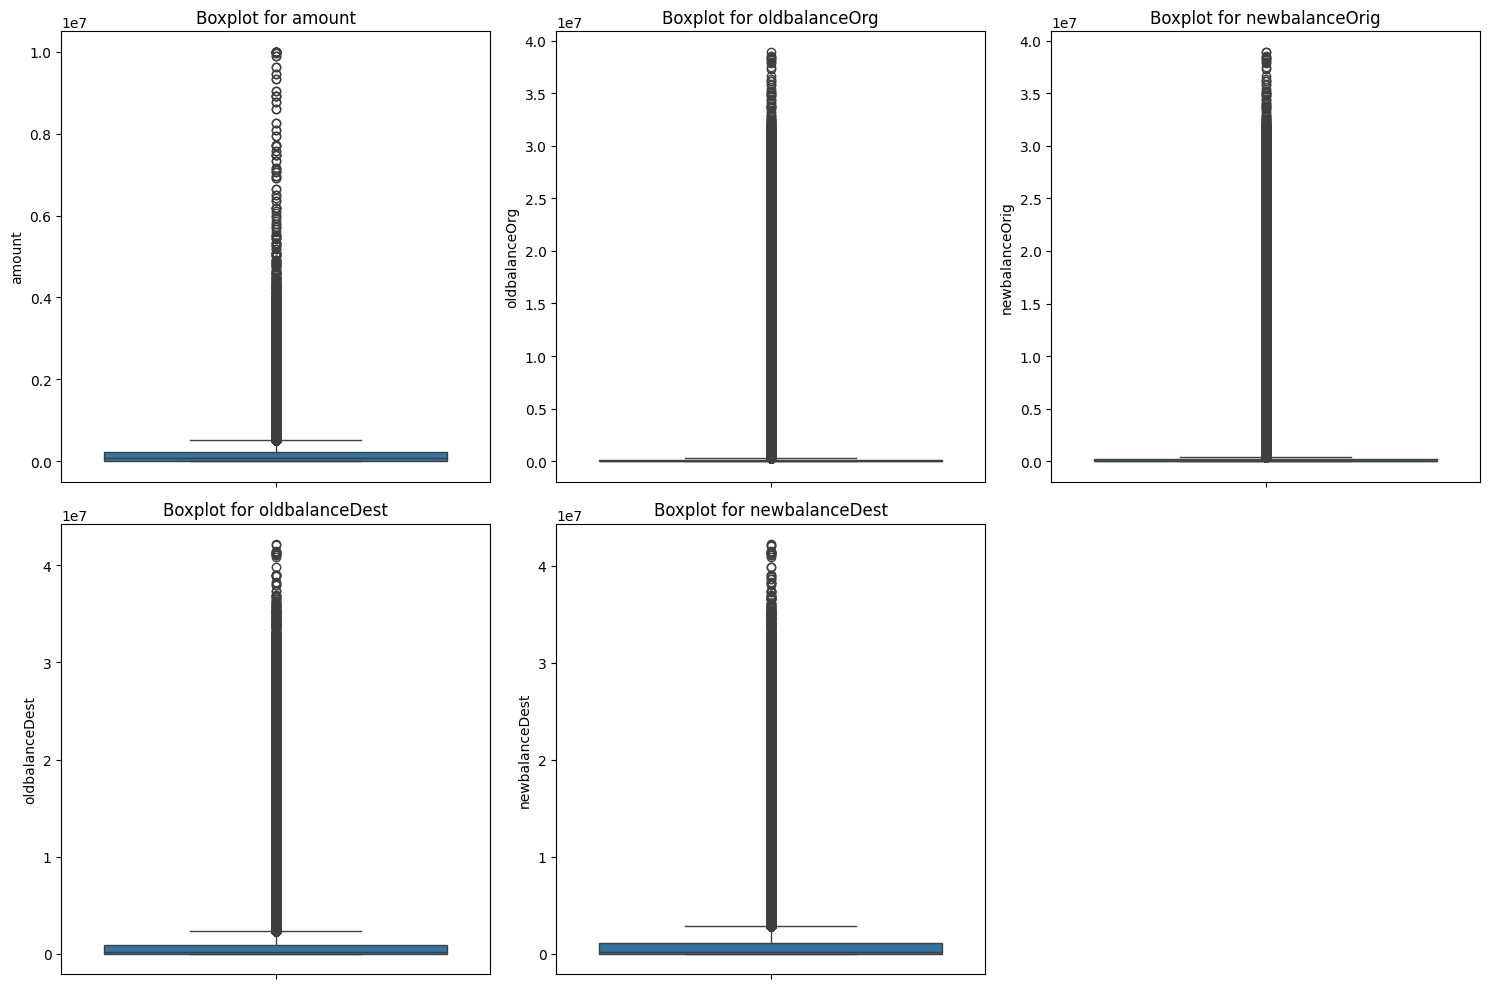

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

num = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
plt.figure(figsize=(15, 10))
for i, column in enumerate(num, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data[column])
    plt.title(f'Boxplot for {column}')
plt.tight_layout()
plt.show()

In [13]:
import numpy as np

def impute(data, columns):
    for column in columns:
        q1 = data[column].quantile(0.25)
        q3 = data[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        median = data[column].median()
        data[column] = np.where((data[column] > upper_bound) | (data[column] < lower_bound), median, data[column])
    return data

clean = impute(data, num)
clean.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


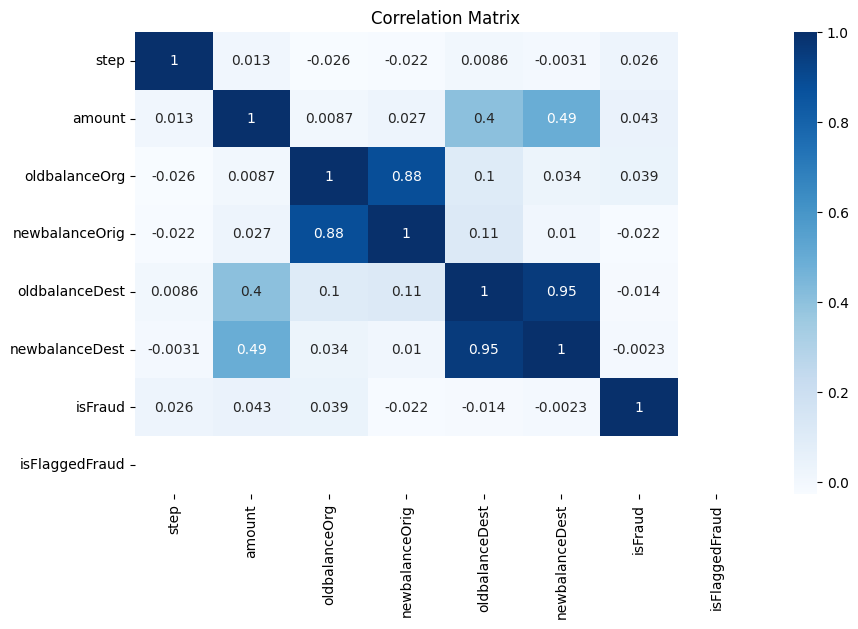

In [53]:
num = data.select_dtypes(include=[np.number])
corrm = num.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corrm, annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

To handle missing values, I first checked for any blank entries in the data and then removed any rows that had missing values. After cleaning the data, I used box plots to identify any unusual values in important numerical features such as amount, old balance at the origin, new balance at the origin, old balance at the destination, and new balance at the destination. To deal with these unusual values, I created a function that calculated the Interquartile Range (IQR) and replaced any values that were too far outside the typical range with the median value of the respective feature. After that, I checked for any relationships between the different features by creating a correlation matrix and visualizing it using a heatmap with Seaborn.

In [18]:
features = data[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
target = data['isFraud']

In [19]:
correlation = features.join(target).corr()['isFraud'].sort_values(ascending=False)
print(correlation)

isFraud           1.000000
amount            0.043188
oldbalanceOrg     0.038749
newbalanceDest   -0.002303
oldbalanceDest   -0.013604
newbalanceOrig   -0.022156
Name: isFraud, dtype: float64


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
importances = model.feature_importances_
featureimp = pd.DataFrame({'Feature': features.columns, 'Importance': importances})
featureimp = featureimp.sort_values(by='Importance', ascending=False)
print(featureimp)

          Feature  Importance
4  newbalanceDest    0.305973
1   oldbalanceOrg    0.266515
0          amount    0.205887
3  oldbalanceDest    0.173389
2  newbalanceOrig    0.048235


I have built a fraud detection model using a Random Forest classifier. I picked this model because it's really good at handling large datasets with lots of different indicators. The way it works is by creating a bunch of decision trees during training and then combining their predictions to decide whether a transaction is fraudulent or legitimate. This approach helps prevent the model from getting too focused on the training data and gives really accurate results, which is crucial for spotting fraud where even a small mistake could have big consequences.

In [21]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, random_state=42)
rfe = RFE(model, n_features_to_select=3)
rfe = rfe.fit(X_train, y_train)
selected = features.columns[rfe.support_]
print("Selected features:", selected)

Selected features: Index(['amount', 'oldbalanceOrg', 'newbalanceOrig'], dtype='object')


I identified the important factors for the model by analyzing correlations and using feature selection techniques. Once I found the key numerical features, I checked how they related to the target variable "isFraud." I also used Recursive Feature Elimination (RFE) with a Logistic Regression model to narrow down the selection further and found that "amount," "oldbalanceOrg," and "newbalanceOrig" were the most important predictors. These were the variables I used to train the model in the end.

In [25]:
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

final = ['amount', 'oldbalanceOrg', 'newbalanceOrig']
X_final = features[final]
X_train_final, X_test_final, y_train, y_test = train_test_split(X_final, target, test_size=0.3, random_state=42)
model.fit(X_train_final, y_train)
yfinal = model.predict(X_test_final)
print(classification_report(y_test, yfinal))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    355429
         1.0       0.00      0.00      0.00       468

    accuracy                           1.00    355897
   macro avg       0.50      0.50      0.50    355897
weighted avg       1.00      1.00      1.00    355897



Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    355429
         1.0       0.74      0.43      0.54       468

    accuracy                           1.00    355897
   macro avg       0.87      0.71      0.77    355897
weighted avg       1.00      1.00      1.00    355897

Confusion Matrix:
 [[355358     71]
 [   267    201]]
Accuracy Score: 0.9990502870212449
ROC-AUC Score: 0.9705308179043439


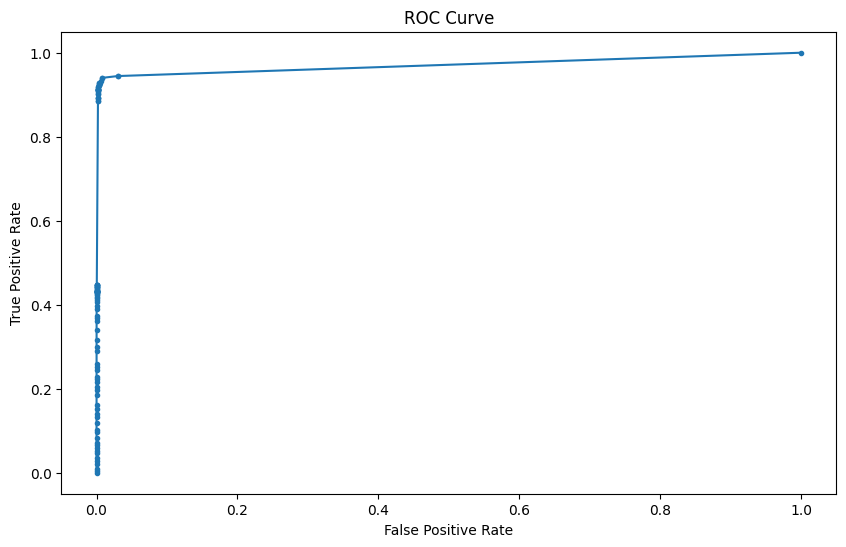

In [34]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_final, y_train)
yfinal = model.predict(X_test_final)
y_proba_final = model.predict_proba(X_test_final)[:, 1]
print("Classification Report:\n", classification_report(y_test, yfinal))
print("Confusion Matrix:\n", confusion_matrix(y_test, yfinal))
print("Accuracy Score:", accuracy_score(y_test, yfinal))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_final))
false, true, _ = roc_curve(y_test, y_proba_final)
plt.figure(figsize=(10, 6))
plt.plot(false, true, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

After training the model, I split the data into a 70/30 train-test split and evaluated its performance using various metrics. The classification report gave me insights into precision, recall, and F1-score, while the confusion matrix showed the true positives, true negatives, false positives, and false negatives. I also calculated the accuracy score and plotted the ROC curve to see how well the model can distinguish between fraudulent and legitimate transactions. The final ROC-AUC score confirmed that the model performed really well.

In [31]:
importances = model.feature_importances_
featureimp = pd.DataFrame({'Feature': final, 'Importance': importances})
featureimp = featureimp.sort_values(by='Importance', ascending=False)
print("Feature Importances:\n", featureimp)

Feature Importances:
           Feature  Importance
0          amount    0.492909
1   oldbalanceOrg    0.462983
2  newbalanceOrig    0.044108


I found that the most important factors for predicting fraudulent customers in my model are the amount of the transaction, the old balance of the originating account, and the new balance of the originating account. Based on their feature importance scores, these features showed the highest importance in the model's predictions. They are directly related to transaction behavior, and any significant anomalies or inconsistencies in these features can strongly indicate potential fraud.

I believe these factors make sense as they directly relate to the financial behavior of the account holder. For example, if the balance after a transaction doesn't match up logically with the balance before it, or if the transaction amount is unusually high or low, these could indicate unauthorized activity. The model's reliance on these factors is therefore both logical and effective in identifying suspicious transactions.

As we work on updating our infrastructure, it's imperative to make sure that our fraud detection system can grow as we grow and stay safe from any potential threats. This involves setting up ways to monitor for fraud as it happens, regularly updating our system with new information to keep up with any new kinds of fraud, and making sure our cybersecurity measures are strong enough to keep our data safe. It's also important to create systems that can learn from any fraud it detects and get better at catching it in the future.

By tracking key performance metrics over time, such as the decline in fraudulent transactions, the accuracy of the model in identifying fraud, and the financial impact of fraud on the company, it is possible to evaluate the efficacy of the taken activities. When these data are regularly analyzed in conjunction with audits and system evaluations, it will be possible to determine whether the preventive measures are effectively lowering the incidence of fraud.